In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from xgboost import plot_importance
from xgboost import plot_tree
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import itertools
from scipy import stats

/Users/FeatureForest/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from statsmodels.stats.diagnostic import lillifors

In [3]:
data = pd.read_excel("/Users/FeatureForest/Documents/Spektra list gatunków Fritillaria.xlsx", sheet_name='DANE KWIATÓW', delimiter=";", decimal=",")

In [4]:
data.head()

,Gatunek,Kolor,Średnica,płatek
0,F. affinis,PUR,26.1,22.86
1,F. affinis,PUR,NaN,24.29
2,F. affinis,PUR,NaN,25.00
3,F. affinis,PUR,NaN,25.00
4,F. affinis,PUR,NaN,23.16


In [5]:
#retruns pollinator
def pollinator(name):
    if((name == 'F. eduardi') | (name == 'F. imperialis')):
        return "PAS"
    elif ((name == "F. recurva") | (name == "F. gentneri")):
        return "HUM"
    else:
        return "INS"

In [6]:
data.head()

,Gatunek,Kolor,Średnica,płatek
0,F. affinis,PUR,26.1,22.86
1,F. affinis,PUR,NaN,24.29
2,F. affinis,PUR,NaN,25.00
3,F. affinis,PUR,NaN,25.00
4,F. affinis,PUR,NaN,23.16


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 4 columns):
Gatunek     1606 non-null object
Kolor       1606 non-null object
Średnica    206 non-null float64
płatek      1146 non-null float64
dtypes: float64(2), object(2)
memory usage: 50.3+ KB


In [8]:
data.Gatunek.unique()

array(['F. affinis', 'F. caucasica', 'F. crassifolia', 'F. eastwoodiae',
       'F. eduardi', 'F. gibbosa', 'F. gracilis', 'F. graeca',
       'F. imperialis', 'F. kothsiana', 'F. latakesis', 'F. liliae',
       'F. michailovski', 'F. meleagroides', 'F. montana', 'F. mutabilis',
       'F. pyreneica', 'F. pontica', 'F. raddeane', 'SER',
       'F. sewerzowii', 'F. sthenanthera', 'F. tubiformis',
       'F. ussuriensis', 'F. uva vulpis', 'F. whitallii', 'F. recurva',
       'F. gentneri', 'F. ariana', 'F. dasyphylla', 'F. minima',
       'F. thunbergii', 'F. armena '], dtype=object)

In [9]:
#data["płatek"] = data.płatek.astype(float)


In [10]:
data.groupby(['Gatunek']).agg({'płatek': 'count'
                                }).reset_index()

,Gatunek,płatek
0,F. affinis,6
1,F. ariana,7
2,F. armena,6
3,F. caucasica,18
4,F. crassifolia,12
5,F. dasyphylla,6
6,F. eastwoodiae,6
7,F. eduardi,45
8,F. gentneri,85
9,F. gibbosa,6


In [11]:
df1 = data.groupby(['Gatunek']).agg({'Średnica': 'mean', 
                                     'płatek': 'mean'
                                }).reset_index()


In [12]:
df1.dropna(inplace=True)

In [13]:
df1['Pollinator'] = df1['Gatunek'].apply(pollinator)

In [14]:
df1.head()

,Gatunek,Średnica,płatek,Pollinator
0,F. affinis,26.10,23.960000,INS
1,F. ariana,26.39,15.281429,INS
2,F. armena,10.00,19.566667,INS
3,F. caucasica,27.93,38.743889,INS
4,F. crassifolia,20.00,15.772500,INS


In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 0 to 32
Data columns (total 4 columns):
Gatunek       33 non-null object
Średnica      33 non-null float64
płatek        33 non-null float64
Pollinator    33 non-null object
dtypes: float64(2), object(2)
memory usage: 1.3+ KB


In [16]:
ins_srednica = df1.Średnica[df1.Pollinator == "INS"]
pas_srednica = df1.Średnica[df1.Pollinator == "PAS"]
hum_srednica = df1.Średnica[df1.Pollinator == "HUM"]

### Testing normality srednica

In [17]:
pVals = pd.Series()
# The scipy normaltest is based on D-Agostino and Pearsons test that
# combines skew and kurtosis to produce an omnibus test of normality.
_, pVals['Omnibus']    = stats.normaltest(ins_srednica)

# Shapiro-Wilk test
_, pVals['Shapiro-Wilk']    = stats.shapiro(ins_srednica)

# Or you can check for normality with Lilliefors-test
_, pVals['Lilliefors']    = lillifors(ins_srednica)

# Alternatively with original Kolmogorov-Smirnov test
_, pVals['Kolmogorov-Smirnov']    = stats.kstest((ins_srednica-np.mean(ins_srednica))/np.std(ins_srednica,ddof=1), 'norm')

print('p-values for all {0} data points: ----------------'.format(len(ins_srednica)))
print(pVals)

if pVals['Omnibus'] > 0.05:
    print('Data are normally distributed')

p-values for all 29 data points: ----------------
Omnibus               0.015539
Shapiro-Wilk          0.023282
Lilliefors            0.200000
Kolmogorov-Smirnov    0.806033
dtype: float64


/Users/FeatureForest/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `lillifors` is deprecated, use `lilliefors` instead!
Use lilliefors, lillifors will be removed in 0.9 
(Note: misspelling missing 'e')
  # Remove the CWD from sys.path while we load stuff.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from statsmodels.stats.libqsturng import psturng

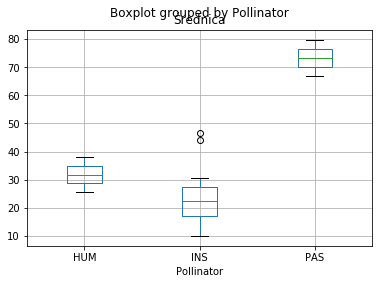

In [19]:
df1.boxplot('Średnica', by='Pollinator')

In [20]:
# First, check if the variances are equal, with the "Levene"-test
(W,p) = stats.levene(ins_srednica, pas_srednica, hum_srednica)
if p<0.05:
    print(('Warning: the p-value of the Levene test is <0.05: p={0}'.format(p)))
else:
    
    print('OK', p)

OK 0.9961632617596949


In [21]:
f, p = stats.f_oneway(ins_srednica,
                      hum_srednica,
                      pas_srednica)
 
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

One-way ANOVA
F value: 33.361213069941336
P value: 2.3654354239800862e-08 



In [22]:
#Then, do the multiple testing
multiComp = MultiComparison(df1['Średnica'], df1['Pollinator'])

In [23]:
print((multiComp.tukeyhsd().summary()))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 HUM    INS   -8.5208  -23.7059  6.6643 False 
 HUM    PAS   41.5239  20.7532  62.2946  True 
 INS    PAS   50.0446  34.8595  65.2297  True 
----------------------------------------------


In [24]:
print(multiComp.kruskal().summary())

MultiComparison.kruskal
0 1 8.551724137931034 12.47359836954681 0.6855859780453821 False
0.4929742262012845


AttributeError: 'numpy.float64' object has no attribute 'summary'

In [25]:
ins_płatek = df1.płatek[df1.Pollinator == "INS"]
pas_płatek = df1.płatek[df1.Pollinator == "PAS"]
hum_płatek = df1.płatek[df1.Pollinator == "HUM"]

In [26]:
# First, check if the variances are equal, with the "Levene"-test
(W,p) = stats.levene(ins_płatek, pas_płatek, hum_płatek)
if p<0.05:
    print(('Warning: the p-value of the Levene test is <0.05: p={0}'.format(p)))
else:
    
    print('OK', p)

OK 0.2821635786287848


In [27]:
f, p = stats.f_oneway(ins_płatek,
                      hum_płatek,
                      pas_płatek)
 
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

One-way ANOVA
F value: 10.415674064306664
P value: 0.0003671507335156486 



In [28]:
#Then, do the multiple testing
multiComp = MultiComparison(df1['płatek'], df1['Pollinator'])

In [29]:
print((multiComp.tukeyhsd().summary()))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 HUM    INS   -8.4986  -24.3706  7.3735 False 
 HUM    PAS   20.1271  -1.5833  41.8374 False 
 INS    PAS   28.6256  12.7536  44.4977  True 
----------------------------------------------


In [30]:
df1[df1.Pollinator=='PAS']

,Gatunek,Średnica,płatek,Pollinator
7,F. eduardi,79.786250,52.871778,PAS
12,F. imperialis,66.884167,52.026739,PAS


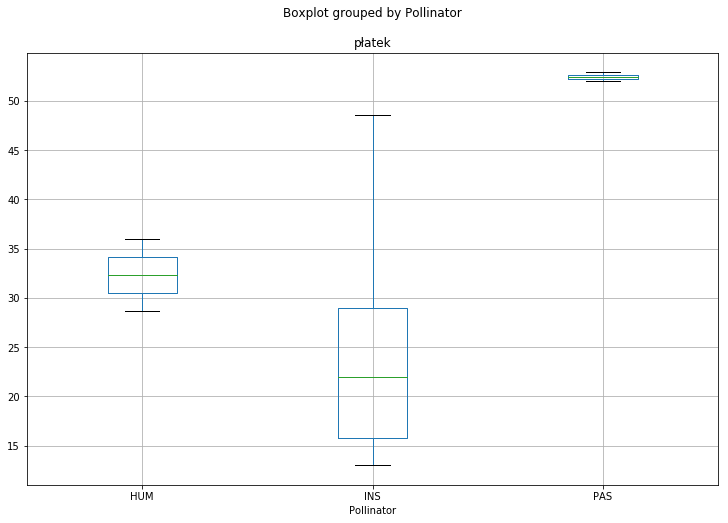

In [31]:
#Create a boxplot
df1.boxplot('płatek', by='Pollinator', figsize=(12, 8))

In [59]:
grub = pd.read_excel("/Users/FeatureForest/Documents/Spektra list gatunków Fritillaria.xlsx", sheet_name='grubość płatka', delimiter=";", decimal=",")

In [60]:
grub.drop(grub.columns[1:23], axis=1, inplace=True)

In [61]:
grub.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 38 entries, 1.0 to 37.0
Data columns (total 4 columns):
sp             38 non-null object
μm             38 non-null float64
sd             38 non-null float64
Unnamed: 25    38 non-null int64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.5+ KB


In [62]:
grub.rename(index=str, columns={"μm": "grub", "Unnamed: 25": "N"}, inplace=True)

In [65]:
grub.reset_index(inplace=True)

In [67]:
grub.drop(grub.columns[0], axis=1, inplace=True)

In [68]:
grub.head()

,sp,grub,sd,N
0,F. affinis,504.600000,49.106415,5
1,F. amana,300.675926,19.680200,4
2,F. armena,620.500218,22.242582,5
3,F. aryiana,427.061799,57.074561,7
4,F. aurea,714.772407,107.565515,8


In [69]:
xls = pd.ExcelFile('/Users/FeatureForest/Documents/Fritillaria Warsaw.xlsx')

In [70]:
names = xls.sheet_names

In [71]:
#list of analysed species
species = ["F. imperialis","F. michailovskyi",'F. whittallii','F. tubiformis','F. gracilis',
           'F. eduardii','F. minima','F. thunbergii','F. eastwoodiae', "F. liliaceae", 
           "F. liliaceae", "F. kurdica",'F. pyrenaica', 'F. pontica', 'F. thunbergii',
           'F. uva vulpis', 'F. affinis','F. montana',  'F. aryiana', 'F. dasyphylla', 
           'F. verticillata','F. serpenticola', 'F. mutabilis', 'F. raddeana', 'F. graeca', 
           'F. caucasica', 'F. gibbosa', 'F. armena','F. stenanthera','F. ussuriensis',
           'F. kotschyana','F. meleagris', "F. michailovskyi", 'F. latakesis', 'F. gentneri',
          'F. recurva', 'F. sewerzowii']

In [73]:
import re

In [96]:
outside = []
pattern = ".+ou.+"
outside = [x for x in names if re.match(pattern,x)]

In [97]:
outside

['Sp1 outside',
 'Sp2 Yellow inside and outside',
 'Sp2 Red outside',
 'Sp3 green inside and outside',
 'Sp3 red outside',
 'Sp4 ouside',
 'Sp5 outside',
 'Sp6 outside',
 'Sp7 inside and outside',
 'Sp8 outside',
 'Sp9 outside',
 'Sp10 inside and outside',
 'Sp11 outside',
 'Sp12 outside',
 'Sp13 outside',
 'Sp14 outside green',
 'Sp14 red inside and outside',
 'Sp15 petaltip inside outside',
 'Sp15 outside',
 'Sp16 red inside and outside',
 'Sp16 yellow inside and outside',
 'Sp17 outside',
 'Sp18 outside',
 'Sp19 inside and outside',
 'Sp20 inside and outside',
 'Sp21 outside',
 'Sp22 inside and outside',
 'Sp23 inside and outside',
 'Sp24 inside and outsider',
 'Sp25 outside',
 'Sp26 outside',
 'Sp27 inside and outside',
 'Sp28 outside',
 'Sp29 inside and outside',
 'Sp30 outside',
 'Sp31 outside green',
 'Sp31 outside red',
 'Sp32 outside',
 'Sp33 outside red',
 'Sp33 yellow inside and outside',
 'Sp34 green outside and inside',
 'Sp34 red outside and inside',
 'Sp35 inside and out

In [99]:
#removing reflectance in other than red
indexes = [1,3,15,17,20,35,39,40]
for index in sorted(indexes, reverse=True):
    del outside[index]

In [100]:
outside

['Sp1 outside',
 'Sp2 Red outside',
 'Sp3 red outside',
 'Sp4 ouside',
 'Sp5 outside',
 'Sp6 outside',
 'Sp7 inside and outside',
 'Sp8 outside',
 'Sp9 outside',
 'Sp10 inside and outside',
 'Sp11 outside',
 'Sp12 outside',
 'Sp13 outside',
 'Sp14 red inside and outside',
 'Sp15 outside',
 'Sp16 red inside and outside',
 'Sp17 outside',
 'Sp18 outside',
 'Sp19 inside and outside',
 'Sp20 inside and outside',
 'Sp21 outside',
 'Sp22 inside and outside',
 'Sp23 inside and outside',
 'Sp24 inside and outsider',
 'Sp25 outside',
 'Sp26 outside',
 'Sp27 inside and outside',
 'Sp28 outside',
 'Sp29 inside and outside',
 'Sp30 outside',
 'Sp31 outside red',
 'Sp32 outside',
 'Sp33 outside red',
 'Sp34 red outside and inside',
 'Sp35 inside and outside',
 'Sp36 inside and outside',
 'Sp37 outside']

In [101]:
indexes_outside = []
for i in range(len(outside)):
    indexes_outside.append(names.index(outside[i]))

sheets_outside = []
for i in range(len(outside)):
    sheet = xls.parse(indexes_outside[i])
    sheets_outside.append(sheet)

In [102]:
#returns UV & visible spectrum
for i in range(len(sheets_outside)):
    sheets_outside[i] = sheets_outside[i][(sheets_outside[i].nm > 300) & (sheets_outside[i].nm < 700)]

In [104]:
#columns wiht reflectancy value
columns_ref = sheets_outside[0].columns[1::2]

In [105]:
#returns mean of wavelengths (relative)
for i in range(len(sheets_outside)):
    sheets_outside[i] = sheets_outside[i].assign(mean=sheets_outside[i][columns_ref].mean(axis=1)/1000)

In [107]:
from functools import reduce

In [132]:
sheets_outside[0]

,nm,1,nm.1,2,nm.2,3,nm.3,4,nm.4,5,mean
321,300.34,7167,300.34,7112,300.34,6915,300.34,7032,300.34,6963,7.0378
322,300.71,7173,300.71,7128,300.71,7034,300.71,7098,300.71,7021,7.0908
323,301.07,7184,301.07,7201,301.07,7157,301.07,7116,301.07,7132,7.1580
324,301.44,7189,301.44,7225,301.44,7168,301.44,7147,301.44,7198,7.1854
325,301.81,7249,301.81,7268,301.81,7210,301.81,7250,301.81,7245,7.2444
326,302.18,7354,302.18,7273,302.18,7202,302.18,7276,302.18,7309,7.2828
327,302.55,7336,302.55,7286,302.55,7161,302.55,7303,302.55,7396,7.2964
328,302.91,7303,302.91,7336,302.91,7224,302.91,7386,302.91,7452,7.3402
329,303.28,7373,303.28,7296,303.28,7188,303.28,7490,303.28,7444,7.3582
330,303.65,7483,303.65,7244,303.65,7203,303.65,7491,303.65,7327,7.3496


In [126]:
numbers = []
for i in range(1,38):
    numbers.append("Sp"+str(i))
nms = list(zip(numbers, species))
outside_species = []
for i in range(9):
    outside_species.append(reduce(lambda a, kv: a.replace(*kv), nms, outside[i])) 

In [130]:
for i in range(9, len(outside)):
    outside_species.append(reduce(lambda a, kv: a.replace(*kv), nms[9:], outside[i])) 

In [143]:
(outside_species)

['F. imperialis outside',
 'F. michailovskyi Red outside',
 'F. whittallii red outside',
 'F. tubiformis ouside',
 'F. gracilis outside',
 'F. eduardii outside',
 'F. minima inside and outside',
 'F. thunbergii outside',
 'F. eastwoodiae outside',
 'F. liliaceae inside and outside',
 'F. liliaceae outside',
 'F. kurdica outside',
 'F. pyrenaica outside',
 'F. pontica red inside and outside',
 'F. thunbergii outside',
 'F. uva vulpis red inside and outside',
 'F. affinis outside',
 'F. montana outside',
 'F. aryiana inside and outside',
 'F. dasyphylla inside and outside',
 'F. verticillata outside',
 'F. serpenticola inside and outside',
 'F. mutabilis inside and outside',
 'F. raddeana inside and outsider',
 'F. graeca outside',
 'F. caucasica outside',
 'F. gibbosa inside and outside',
 'F. armena outside',
 'F. stenanthera inside and outside',
 'F. ussuriensis outside',
 'F. kotschyana outside red',
 'F. meleagris outside',
 'F. michailovskyi outside red',
 'F. latakesis red outside

In [144]:
len(species)

37

In [139]:
srednia = []
for i in range(len(sheets_outside)):
    srednia.append(sheets_outside[i]['mean'].mean())

In [140]:
len(srednia)

37

In [141]:
srednia

[36.74288707718996,
 13.05385828274068,
 3.288491486730266,
 22.353346400693813,
 11.291389939288795,
 12.215779358196011,
 26.40663226366001,
 15.297238334778843,
 5.944222376409357,
 42.45723451864697,
 23.506988551604504,
 12.547014865741534,
 23.963595490026034,
 3.4297385831743292,
 11.317871812662604,
 8.567079791847354,
 4.991691934084999,
 27.824426539462273,
 29.57530615784915,
 25.952136339982648,
 37.17110060711188,
 13.082361471465743,
 32.003935819601026,
 22.247335789765806,
 4.81184770164787,
 10.953881699913287,
 53.21551777970512,
 14.747499913269737,
 29.28663885516045,
 13.371892454466613,
 9.266037120555072,
 5.443288638334779,
 3.3910663573287074,
 13.901895750216825,
 14.087926973113591,
 8.308935299219428,
 17.767390980052035]

In [145]:
reflektancja = pd.DataFrame(
    {'Gatunek': species,
     'srednia': srednia
    })

In [146]:
reflektancja

,Gatunek,srednia
0,F. imperialis,36.742887
1,F. michailovskyi,13.053858
2,F. whittallii,3.288491
3,F. tubiformis,22.353346
4,F. gracilis,11.291390
5,F. eduardii,12.215779
6,F. minima,26.406632
7,F. thunbergii,15.297238
8,F. eastwoodiae,5.944222
9,F. liliaceae,42.457235


In [147]:
grub

,sp,grub,sd,N
0,F. affinis,504.600000,49.106415,5
1,F. amana,300.675926,19.680200,4
2,F. armena,620.500218,22.242582,5
3,F. aryiana,427.061799,57.074561,7
4,F. aurea,714.772407,107.565515,8
5,F. caucasica,632.798222,76.771188,10
6,F. dasyphylla,557.800000,45.004000,5
7,F. eastwoodiae,463.812778,47.375421,8
8,F. eduardii,964.971287,134.963390,19
9,F. gentneri,543.723148,140.982127,8


In [150]:
df = pd.merge(reflektancja, grub, how='inner', left_on='Gatunek', right_on='sp')

In [151]:
df

,Gatunek,srednia,sp,grub,sd,N
0,F. imperialis,36.742887,F. imperialis,856.232222,117.473314,9
1,F. whittallii,3.288491,F. whittallii,763.310588,74.625613,8
2,F. tubiformis,22.353346,F. tubiformis,678.394099,99.552051,7
3,F. gracilis,11.291390,F. gracilis,513.899290,98.215369,12
4,F. eduardii,12.215779,F. eduardii,964.971287,134.963390,19
5,F. minima,26.406632,F. minima,438.770370,33.114669,5
6,F. thunbergii,15.297238,F. thunbergii,470.000000,0.000000,1
7,F. thunbergii,11.317872,F. thunbergii,470.000000,0.000000,1
8,F. eastwoodiae,5.944222,F. eastwoodiae,463.812778,47.375421,8
9,F. liliaceae,42.457235,F. liliaceae,527.744370,47.781845,5


In [152]:
df['srednia'].corr(df['grub'])

0.02229597028109618

In [155]:
#retruns pollinator
def pollinator(name):
    if((name == 'F. eduardii') | (name == 'F. imperialis')):
        return "PAS"
    elif ((name == "F. recurva") | (name == "F. gentneri")):
        return "HUM"
    else:
        return "INS"

In [156]:
df['Pollinator'] = df['Gatunek'].apply(pollinator)

In [157]:
df

,Gatunek,srednia,sp,grub,sd,N,Pollinator
0,F. imperialis,36.742887,F. imperialis,856.232222,117.473314,9,PAS
1,F. whittallii,3.288491,F. whittallii,763.310588,74.625613,8,INS
2,F. tubiformis,22.353346,F. tubiformis,678.394099,99.552051,7,INS
3,F. gracilis,11.291390,F. gracilis,513.899290,98.215369,12,INS
4,F. eduardii,12.215779,F. eduardii,964.971287,134.963390,19,PAS
5,F. minima,26.406632,F. minima,438.770370,33.114669,5,INS
6,F. thunbergii,15.297238,F. thunbergii,470.000000,0.000000,1,INS
7,F. thunbergii,11.317872,F. thunbergii,470.000000,0.000000,1,INS
8,F. eastwoodiae,5.944222,F. eastwoodiae,463.812778,47.375421,8,INS
9,F. liliaceae,42.457235,F. liliaceae,527.744370,47.781845,5,INS


In [158]:
ins = df[df.Pollinator == "INS"]

In [160]:
ins['srednia'].corr(ins['grub'])

-0.05259786333163015

In [161]:
hum = df[df.Pollinator == "HUM"]

In [162]:
hum['srednia'].corr(hum['grub'])

1.0

In [163]:
pas = df[df.Pollinator == "PAS"]
pas['srednia'].corr(pas['grub'])

-1.0